# How do errors propagate through the pseudobatch transformation?

In [1]:
import logging
import os

from functools import partial
from itertools import islice
from pprint import pprint
from typing import Union

import arviz as az
import cmdstanpy
import numpy as np
import pandas as pd
from tqdm import tqdm
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from scipy.special import logit

from pseudobatch.data_correction import pseudobatch_transform
from pseudobatch.datasets import load_standard_fedbatch
from pseudobatch.error_propagation import run_error_propagation

# Don't print cmdstanpy warnings
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


# Statistical model

In order to understand how the pseudobatch transform propagates errors, we need a statistical model that describes how we think error arises in batch fermentation experiments. Luckily pseudobatch comes with one of those!

## Measurements

The statistical model assumes that the following quantities are measured with natural logarithmic scale errors:

| quantity |symbol for true value | symbol for measured value | symbol for $\ln$ scale error |
|----------|----------------------|-------------------------- |----------------------------- |
|container volume|$v$|$y_v$|$\sigma_v$||
|species concentration|$c$|$y_c$|$\sigma_c$|
|feed volume|$f$|$y_f$|$\sigma_f$|
|sample volume|$s$|$y_s$|$\sigma_s$|
|feed concentration|$cfeed$|$y_{cfeed}$|$\sigma_{cfeed}$|

The probabilistic relationship between the true values and the measured values is modelled as follows:

\begin{align*}
y_v &\sim LN(\ln{v}, \sigma_v) \\
y_c &\sim LN(\ln{c}, \sigma_c) \\
y_f &\sim LN(\ln{f + a_{pump}}, \sigma_f) \\
y_s &\sim LN(\ln{s}, \sigma_s) \\
y_{cfeed} &\sim LN(\ln{cfeed}, \sigma_{cfeed})
\end{align*}

In these equations $LN$ stands for the lognormal distribution with standard location and scale parameterisation. 

Note that the model for feed measurements includes a term $a_{pump}$. This is to model the effect of an unknown but common-to-all-measurements bias in feed measurements due to an inaccurate pump.

## Known quantities

As well as the values of all measurements, our model also assumes that the measurement errors are known exactly. These values are stored in a Python dictionary in the cell below:

In [2]:
MEASUREMENT_ERRORS = {
    "sd_reactor_volume": 0.05,
    "sd_concentration": [0.05] * 3,
    "sd_feed_in_interval": 0.05,
    "sd_sample_volume": 0.05,
    "sd_concentration_in_feed": 0.05
}

## Unknown quantities

The model also has unknown quantities. These are:

|symbol| Description|
|------|------------|
|$v_0$ | the volume of the container at the start of the experiment.|
|$m$ | a vector of per-sample species masses.|
|$a_s$| a vector of per-sample volumes, expressed as logit-scale fractions of the pre-sample volume.|
|$f_{nz}$| a vector containing the feed volume for each pre-sample interval where feeding took place.|
|$cf_{nz}$ | the concentration of feed in the feed solution if any.|
|$a_{pump}$| the factor according to which measurements of feed volume are biased, on $\ln$ scale|

Other quantities in the model---for example, the smaple volumes $v$---are calculated based on the values of the unknowns above. This parameterisation was chosen in order to ensure that independent prior distributions would be appropriate.

## Priors

The next cell shows the informative independent priors we chose for each unknown quantity. Note that the priors are specified by setting the 1% and 99% percentiles. Ideally, ignoring the measurement results there should be a 99% probability of the true value being greater than the 1% percentile and a 99% probability of the true value being lower than the 99% percentile.


In [3]:
PRIORS = {
    "prior_apump": {"pct1": np.log(1 - 0.1), "pct99": np.log(1 + 0.1)},
    "prior_as": {"pct1": logit(0.05), "pct99": logit(0.4)},
    "prior_v0": {"pct1": 1000, "pct99": 1030},
    "prior_f_nonzero": {"pct1": 10, "pct99": 1000},
    "prior_cfeed": [{"loc": 0, "scale": 1}, {"pct1": 99, "pct99": 101}, {"loc": 0, "scale": 1}],
}

# Load data

This cell loads some data and adds some useful columns.

In [4]:
SPECIES = ["Biomass", "Glucose", "Product"]

samples = load_standard_fedbatch(sampling_points_only=True)
samples["v_Feed_interval"] = np.concatenate(
    [np.array([samples["v_Feed_accum"].iloc[0]]), np.diff(samples["v_Feed_accum"])]
)
for species in SPECIES:
    samples[f"c_{species}_pseudobatch"] = pseudobatch_transform(
        measured_concentration=samples[f"c_{species}"],
        reactor_volume=samples["v_Volume"],
        accumulated_feed=samples["v_Feed_accum"],
        concentration_in_feed=100 if species == "Glucose" else 0,
        sample_volume=samples["sample_volume"],
    )
samples.head().T

,0,1,2,3,4
Kc_s,0.150000,0.150000,0.150000,0.150000,0.150000
mu_max,0.300000,0.300000,0.300000,0.300000,0.300000
Yxs,1.850000,1.850000,1.850000,1.850000,1.850000
Yxp,0.821510,0.821510,0.821510,0.821510,0.821510
Yxco2,0.045193,0.045193,0.045193,0.045193,0.045193
F0,0.062881,0.062881,0.062881,0.062881,0.062881
mu0,0.100000,0.100000,0.100000,0.100000,0.100000
s_f,100.000000,100.000000,100.000000,100.000000,100.000000
sample_volume,170.000000,170.000000,170.000000,170.000000,170.000000
timestamp,10.000000,17.142857,24.285714,31.428571,38.571429


# Run error propagation

This cell runs the pseudobatch error propagation.

In [5]:
ERROR_PROPAGATION_ARGS = {       
    "y_concentration": samples[[f"c_{species}" for species in SPECIES]],
    "y_reactor_volume": samples["v_Volume"],
    "y_feed_in_interval": samples["v_Feed_interval"],
    "y_sample_volume": samples["sample_volume"],
    "y_concentration_in_feed": np.array([0., 100, 0.]),
    "prior_input": PRIORS,
    "species_names": SPECIES
} | MEASUREMENT_ERRORS
idata = run_error_propagation(**ERROR_PROPAGATION_ARGS)

display(az.summary(idata.sample_stats))
idata

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lp,-116.733,4.758,-125.821,-108.404,0.109,0.077,1889.0,2384.0,1.00
acceptance_rate,0.888,0.102,0.698,1.000,0.001,0.001,5407.0,3901.0,1.00
step_size,0.363,0.012,0.353,0.383,0.006,0.004,4.0,4.0,inf
tree_depth,3.754,0.439,3.000,4.000,0.051,0.036,81.0,71.0,1.04
n_steps,14.464,4.797,7.000,15.000,0.258,0.182,168.0,118.0,1.02
diverging,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
energy,138.257,6.625,126.165,150.578,0.165,0.117,1635.0,2346.0,1.00


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> sample_stats_prior

Convert results to arviz `InferenceData`.

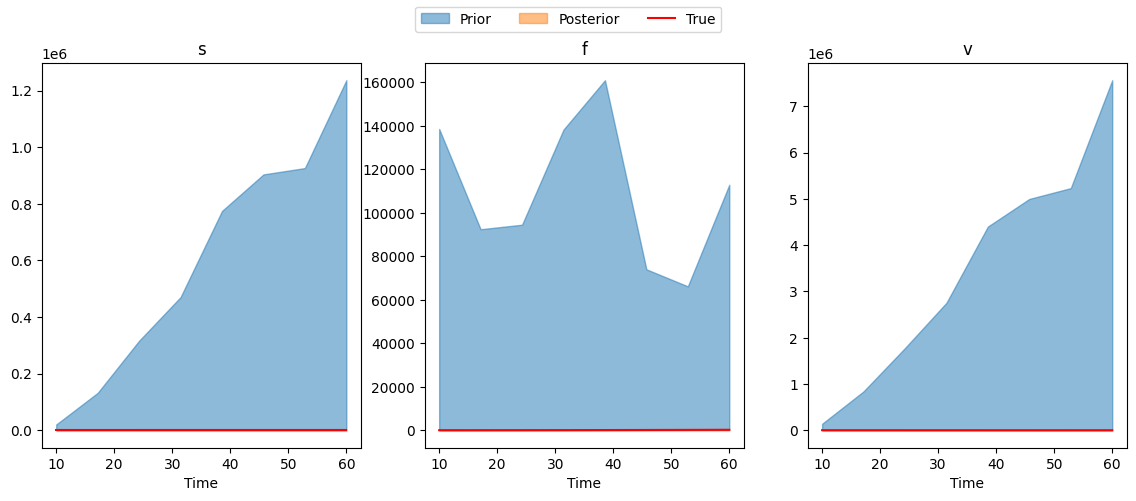

In [6]:
def plot_timecourse_qs(
    ax: plt.Axes,
    varname: str, 
    idata_group: xr.Dataset, 
    timepoints: pd.Series,
    coords: dict,
    quantiles: list = [0.025, 0.975],
    **fill_between_kwargs
) -> PolyCollection:
    var_draws = idata_group[varname]
    for k, v in coords.items():
        if k in var_draws.coords:
            var_draws = var_draws.sel({k:v})
    qs = var_draws.quantile(quantiles, dim=["chain", "draw"]).to_dataframe()[varname].unstack("quantile")
    low = qs[0.025].values
    high = qs[0.975].values
    x = timepoints.values
    return ax.fill_between(x, low, high, **fill_between_kwargs)


f, axes = plt.subplots(1, 3, figsize=[14, 5])
for ax, varname, true_value_colname in zip(
    axes, 
    ["s", "f", "v"], 
    ["sample_volume", "v_Feed_interval", "v_Volume"]
):
    pcs = []
    for idata_group, color in zip([idata.prior, idata.posterior], ["tab:blue", "tab:orange"]):
        pc = plot_timecourse_qs(
            ax,
            varname,
            idata_group,
            samples["timestamp"],
            {"species": ["Product"]},
            color=color,
            alpha=0.5,
        )
        pcs += [pc]
    line = ax.plot(samples["timestamp"], samples[true_value_colname], color="red")
    txt = ax.set(xlabel="Time", title=varname)
legend = f.legend([*pcs, line[0]], ["Prior", "Posterior", "True"], ncol=3, loc="upper center")

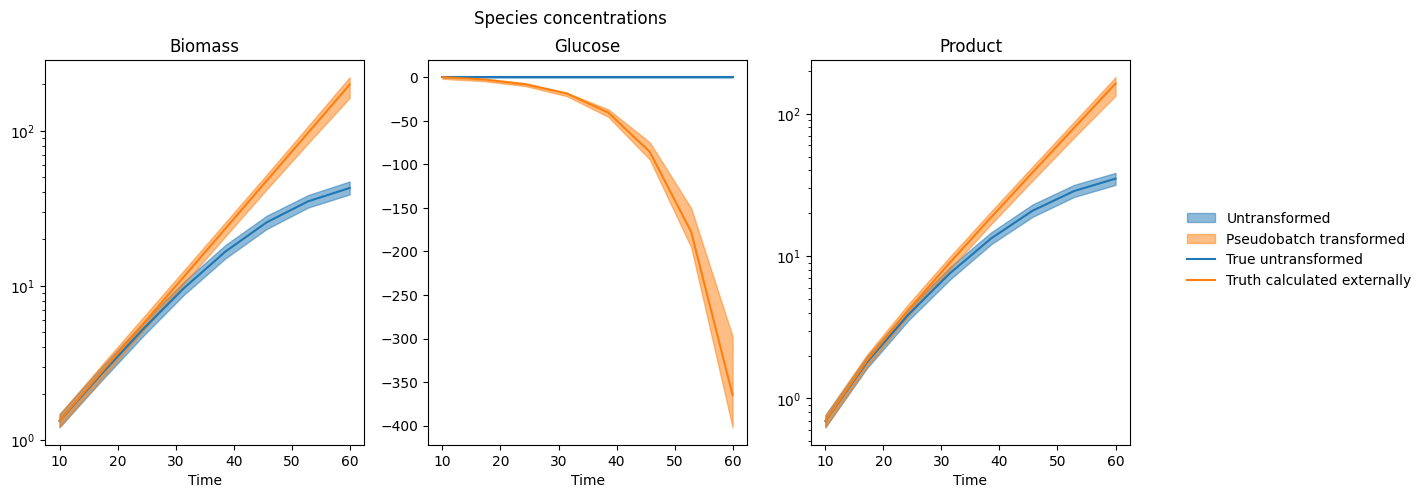

In [7]:
f, axes = plt.subplots(1, 3, figsize=[14, 5])
for ax, species in zip(axes, SPECIES):
    pcs = []
    line_patches = []
    for var, color in zip(["c", "pseudobatch_c"], ["tab:blue", "tab:orange"]):
        true_value_colname = "c_" + species if var == "c" else f"c_{species}_pseudobatch"
        pc = plot_timecourse_qs(
            ax,
            var,
            idata.posterior,
            samples["timestamp"],
            {"species": [species]},
            color=color,
            alpha=0.5,
        )
        pcs += [pc]
        line = ax.plot(samples["timestamp"], samples[true_value_colname], color=color)
        line_patches += [line[-1]]
    txt = ax.set(xlabel="Time", title=species)
    if all(samples[true_value_colname] > 0):
        
        ax.semilogy()

f.suptitle("Species concentrations")
legend = f.legend(
    [*pcs, *line_patches],
    ["Untransformed", "Pseudobatch transformed", "True untransformed", "Truth calculated externally"],
    ncol=1, 
    loc="right", 
    frameon=False,
    bbox_to_anchor = [1.11, 0.5]
)

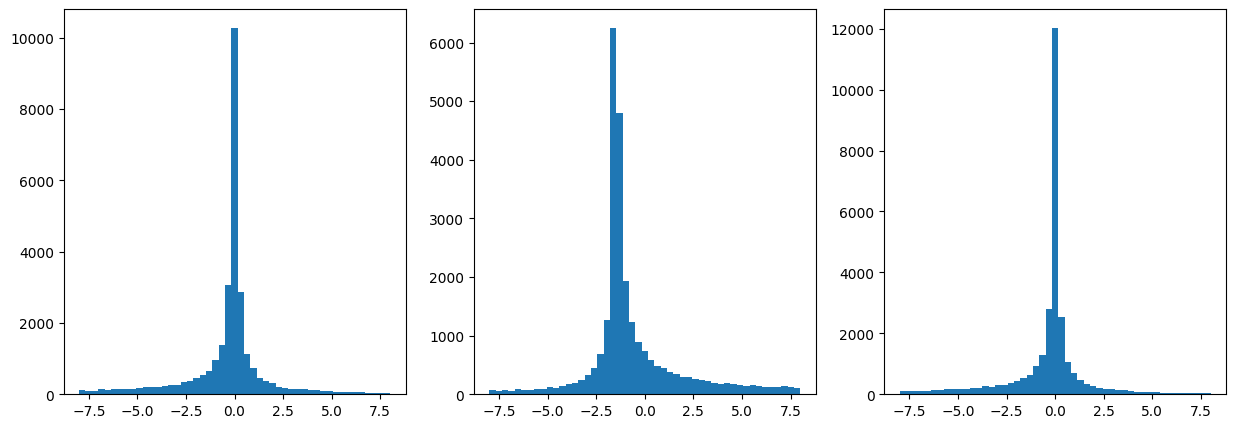

In [8]:
f, axes = plt.subplots(1, 3, figsize=[15, 5])

for species, ax in zip(SPECIES, axes):
    true = xr.DataArray(samples[f"c_{species}_pseudobatch"], dims="sample")
    resids = idata.posterior["pseudobatch_c"].sel(species=species) - true
    hist = ax.hist(resids.values.reshape(-1), bins=np.linspace(-8, 8, 50))

# Compare raw and pseudobatch-transformed product concentration uncertainty

In the next cell we try systematically changing the measurement error for $y_{c}$, then running the model in posterior mode and saving the width of the 99% posterior interval for the last value of $c$ in a dictionary called `widths`.

In [9]:
def coefficient_of_variation(x: Union[np.array, xr.DataArray]) -> float:
    """Calculate the coefficient of variation of a series"""
    return x.std() / x.mean()


comparison_vars = ["pseudobatch_c", "c"]
sigma_c_range = np.linspace(0.01, 1, 30)
cs_of_v = pd.DataFrame(
    index=sigma_c_range, 
    columns=pd.MultiIndex.from_product([SPECIES, comparison_vars])
)
last_sample_idx = samples.shape[0] - 1 # 0-indexation is used 
idata_ensemble = {}
for sigma_c in tqdm(sigma_c_range):
    ep_args_iter = ERROR_PROPAGATION_ARGS | {"sd_concentration": [sigma_c] * 3}
    idata_iter = run_error_propagation(**ep_args_iter)
    for species in SPECIES:
        cs_of_v.loc[sigma_c, species][comparison_vars] = (
            idata_iter
            .posterior[comparison_vars]
            .sel(sample=last_sample_idx, species=species)
            .map(coefficient_of_variation)
            .to_pandas()
        )
        idata_ensemble[sigma_c] = idata_iter
cs_of_v

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:41<00:00,  3.38s/it]


Biomass                 Glucose                 Product   
         pseudobatch_c         c pseudobatch_c         c pseudobatch_c   
0.010000      0.057511  0.010006      -0.07295  0.009977       0.05762  \
0.044138      0.073764  0.044356     -0.075221  0.043807      0.072952   
0.078276      0.096969  0.078751     -0.075768  0.078349      0.100895   
0.112414      0.127455  0.112022     -0.074243  0.110877      0.131267   
0.146552      0.160274  0.148418     -0.076525  0.145558      0.162286   
0.180690      0.190294  0.180463     -0.074529  0.183659      0.187986   
0.214828      0.228682  0.216712     -0.076537  0.215015      0.227636   
0.248966      0.255241  0.246628     -0.075741  0.248624      0.265314   
0.283103      0.293307  0.287657     -0.074304  0.286377      0.299167   
0.317241      0.322962  0.315963     -0.077072  0.332292       0.33173   
0.351379      0.364406  0.360369     -0.074906  0.359009       0.36854   
0.385517      0.397803  0.391099     -0.075912  0.409882      0.410644   
0.419655      0.433277  0.427384      -0.07542  0.441532      0.444514   
0.453793      0.483888  0.478585     -0.076418  0.468275      0.481785   
0.487931      0.511198  0.510772     -0.076693  0.528118      0.530959   
0.522069      0.560364  0.556762     -0.074218  0.567439      0.556635   
0.556207      0.586015  0.581968     -0.074371  0.595504      0.611218   
0.590345      0.633927  0.631204     -0.076362  0.609682      0.636908   
0.624483      0.719774  0.713892     -0.074932  0.692514      0.694855   
0.658621      0.751921  0.747779      -0.07482  0.732286      0.719262   
0.692759      0.779123  0.771451     -0.076387  0.780992      0.752594   
0.726897      0.836577  0.838392     -0.072837  0.843528      0.816959   
0.761034      0.866888  0.865525      -0.07458  0.828626      0.868283   
0.795172      0.935145  0.929053     -0.072981  0.953094      0.944654   
0.829310      0.960552  0.957393     -0.074138  0.991504       1.00646   
0.863448      1.040397  1.044067     -0.076058  1.081668      1.069062   
0.897586      1.136723  1.136113     -0.075298  1.170594      1.132582   
0.931724      1.186083   1.17801     -0.075958   1.22619      1.183163   
0.965862      1.230167  1.226511     -0.074272   1.19218       1.22674   
1.000000      1.296715  1.284012     -0.074106  1.443814      1.500036   

                    
                 c  
0.010000  0.010143  
0.044138  0.043439  
0.078276  0.081184  
0.112414  0.116206  
0.146552  0.149408  
0.180690  0.180403  
0.214828  0.219949  
0.248966  0.259371  
0.283103  0.293028  
0.317241  0.325882  
0.351379  0.363442  
0.385517  0.405929  
0.419655  0.438954  
0.453793  0.476829  
0.487931  0.526502  
0.522069  0.552275  
0.556207  0.611277  
0.590345  0.634441  
0.624483  0.691039  
0.658621  0.719978  
0.692759  0.750486  
0.726897  0.812202  
0.761034  0.863663  
0.795172  0.941725  
0.829310  1.002189  
0.863448  1.061232  
0.897586  1.121583  
0.931724  1.175714  
0.965862  1.214775  
1.000000  1.482683

The next cell plots the transformed and untransformed coefficients of variation against each other.

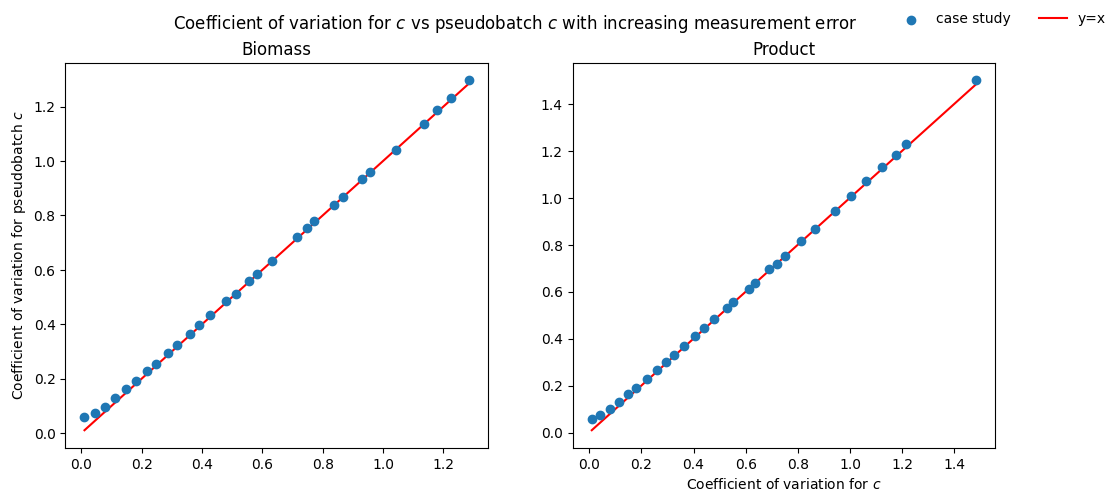

In [10]:
f, axes = plt.subplots(1, 2, figsize=[12, 5])
f.suptitle("Coefficient of variation for $c$ vs pseudobatch $c$ with increasing measurement error")
for ax, species in zip(axes, [s for s in SPECIES if s != "Glucose"]):
    scatter = ax.scatter(cs_of_v[species]["c"], cs_of_v[species]["pseudobatch_c"])
    line = ax.plot(cs_of_v[species]["c"], cs_of_v[species]["c"], color="red", zorder=0)
    text = ax.set(title=species)
leg = f.legend([scatter, line[-1]], ["case study", "y=x"], ncol=2, frameon=False)
xlabel = axes[1].set(xlabel="Coefficient of variation for $c$")
ylabel = axes[0].set(ylabel="Coefficient of variation for pseudobatch $c$")

The coefficient of variation of the untransformed concentrations are approximately the same as those of the pseudobatch transformed concentrations, suggesting that in cases similar to ours the pseudobatch transformation introduces negligible additional error. In the case of glucose (excluded from plot), the uncertainty in the pseudo concentration does not increase as the measurement uncertainty increase. This is because the glucose concentration is very small during the fed-batch process.

In [12]:
# make a function which fits a log-linear model through pandas .apply
def fit_log_linear_model(df):
    x = df["time"].values
    y = df["pseudobatch_c"].values
    logy = np.log(y)
    slope, intercept = np.polyfit(x, logy, deg=1)
    return pd.Series([slope, intercept], index=['slope', 'intercept'])

def fit_yield_linear_model(df, species_col1, species_col2):
    x = df.loc[df.species == species_col1, 'pseudobatch_c'].values
    y = df.loc[df.species == species_col2, 'pseudobatch_c'].values
    slope, intercept = np.polyfit(x, y, deg=1)
    return pd.Series([slope, intercept], index=['slope', 'intercept'])

fitted_growth_rates = pd.DataFrame()
fitted_product_yield = pd.DataFrame()
fitted_substrate_yield = pd.DataFrame()
for sigma_c, idata in islice(idata_ensemble.items(), 0, None, 10):
    # get the posterior of pseudo_batch_c
    posterior_df = (idata
        .posterior['pseudobatch_c'].sel(species=["Biomass", "Glucose", "Product"])
        .to_dataframe()
        .reset_index()
    )
    posterior_df['time'] = posterior_df['sample'].map(samples['timestamp'])

    # fit growth rates
    fitted_growth_rates_tmp = (posterior_df
        .query('species == "Biomass"')
        .groupby(['chain', 'draw'])
        .apply(fit_log_linear_model) 
    )
    # add the sigma_c column
    fitted_growth_rates_tmp['sigma_c'] = sigma_c

    fitted_growth_rates = pd.concat([fitted_growth_rates, fitted_growth_rates_tmp])

    # fit product yield
    fitted_product_yield_tmp = (posterior_df
        .drop(columns=['time', 'sample'])
        .query('species.isin(["Product", "Biomass"])')
        .groupby(['chain', 'draw'])
        .apply(fit_yield_linear_model, "Biomass", "Product")
    )
    fitted_product_yield_tmp['sigma_c'] = sigma_c
    fitted_product_yield = pd.concat([fitted_product_yield, fitted_product_yield_tmp])

    # fit product yield
    fitted_substrate_yield_tmp = (posterior_df
        .drop(columns=['time', 'sample'])
        .query('species.isin(["Glucose", "Biomass"])')
        .groupby(['chain', 'draw'])
        .apply(fit_yield_linear_model, "Biomass", "Glucose")
    )
    fitted_substrate_yield_tmp['sigma_c'] = sigma_c
    fitted_substrate_yield = pd.concat([fitted_substrate_yield, fitted_substrate_yield_tmp])


In [13]:
# Fit parameters for prior predictive distribution
prior_df = (idata
    .prior['pseudobatch_c'].sel(species=["Biomass", "Glucose", "Product"])
    .to_dataframe()
    .reset_index()
)
prior_df['time'] = prior_df['sample'].map(samples['timestamp'])

# fit growth rates
fitted_growth_rates_prior = (prior_df
    .query('species == "Biomass"')
    .groupby(['chain', 'draw'])
    .apply(fit_log_linear_model) 
)


# fit product yield
fitted_product_yield_prior = (prior_df
    .drop(columns=['time', 'sample'])
    .query('species.isin(["Product", "Biomass"])')
    .groupby(['chain', 'draw'])
    .apply(fit_yield_linear_model, "Biomass", "Product")
)

# fit product yield
fitted_substrate_yield_prior = (prior_df
    .drop(columns=['time', 'sample'])
    .query('species.isin(["Glucose", "Biomass"])')
    .groupby(['chain', 'draw'])
    .apply(fit_yield_linear_model, "Biomass", "Glucose")
)

In [14]:
# Create a list of the sigma_c values in descending order
sigma_c_list_descending = fitted_growth_rates['sigma_c'].sort_values(ascending=False).unique()

fitted_growth_rates['sigma_c'] = pd.Categorical(fitted_growth_rates['sigma_c'], categories=sigma_c_list_descending, ordered=True)
fitted_product_yield['sigma_c'] = pd.Categorical(fitted_product_yield['sigma_c'], categories=sigma_c_list_descending, ordered=True)
fitted_substrate_yield['sigma_c'] = pd.Categorical(fitted_substrate_yield['sigma_c'], categories=sigma_c_list_descending, ordered=True)

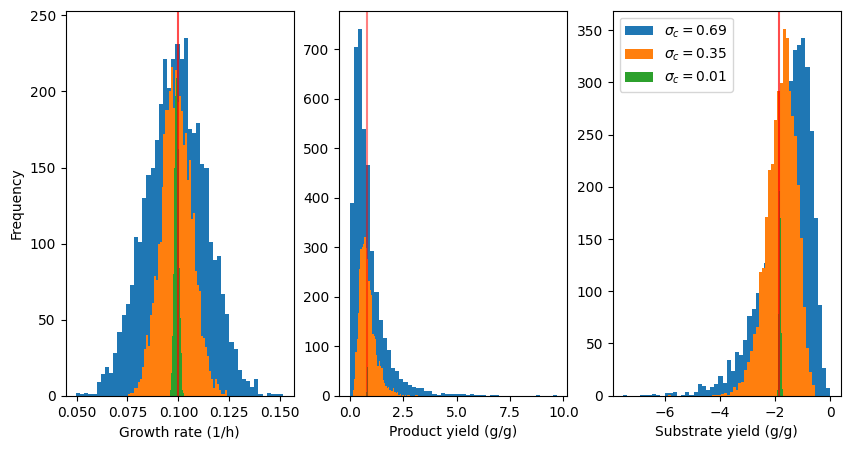

In [15]:
# plot a histogram of the fitted slopes (growth rates)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for sigma_c, group in fitted_growth_rates.groupby('sigma_c'):
    group.slope.plot.hist(bins=50, label=f"$\sigma_c={sigma_c:.2f}$", ax=axes[0])

for sigma_c, group in fitted_product_yield.groupby('sigma_c'):
    group.slope.plot.hist(bins=50, label=f"$\sigma_c={sigma_c:.2f}$", ax=axes[1])

for sigma_c, group in fitted_substrate_yield.groupby('sigma_c'):
    group.slope.plot.hist(bins=50, label=f"$\sigma_c={sigma_c:.2f}$", ax=axes[2])


axes[0].set_xlabel('Growth rate (1/h)')
axes[1].set_xlabel('Product yield (g/g)')
axes[2].set_xlabel('Substrate yield (g/g)')
axes[0].set_ylabel('Frequency')
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
plt.legend()
axes[0].axvline(samples["mu_true"].iloc[0], c="red", alpha=0.7)
axes[1].axvline(samples["Yxp"].iloc[0], c="red", alpha=0.5)
axes[2].axvline(-samples["Yxs"].iloc[0], c="red", alpha=0.7)
fig.savefig("../figures/marginal_dist_of_fitted_parameters.png", dpi=300, bbox_inches="tight")


These histograms are not exactly centered the true values (red line), thus there is a small consistent bias compare the the true values. This bias originates from prior model in the Bayesian model. As the measurement uncertainty increases the posterior distribution is pulled towards the prior distribution (See the table below).

The model utilizes overall priors for the concentrations, thus the model does not take into a account that later values of e.g. biomass are more likely to be large. This biasses all concentration values towards the center of its prior. It would require a more advanced model to overcome this bias. We would like to emphazise that this small bias originates from bayesian pseudo batch transformation model and will NOT affect the results when using the standard version of the pseudo batch transformation (as is also shown in the tutorials).

Finally, we will inspect the 50% quantiles for the estimated parameters at the different measurement errors and compare these the to true value prior predictive values.

In [40]:
# Inspection the 0.5 quantile of the fitted parameters and compare to the true values
posterior_quantiles = pd.concat(
    [
        fitted_growth_rates.groupby('sigma_c').slope.quantile([0.5, 0.25, 0.975]).rename('Growth rate'),
        fitted_product_yield.groupby('sigma_c').slope.quantile([0.5, 0.25, 0.975]).rename('Product yield'),
        fitted_substrate_yield.groupby('sigma_c').slope.quantile([0.5, 0.25, 0.975]).rename('Substrate yield'),
    ],
    axis=1
)
prior_quantiles = pd.concat([
        fitted_growth_rates_prior.slope.quantile([0.5, 0.25, 0.975]).rename('Growth rate'),
        fitted_product_yield_prior.slope.quantile([0.5, 0.25, 0.975]).rename('Product yield'),
        fitted_substrate_yield_prior.slope.quantile([0.5, 0.25, 0.975]).rename('Substrate yield'),
    ], axis=1
)
prior_quantiles.index = [('Prior', quant) for quant in prior_quantiles.index]

estimate_overview_table = pd.concat(
    [
        posterior_quantiles,
        prior_quantiles,
        pd.DataFrame([[
            samples["mu_true"].iloc[0],
            samples["Yxp"].iloc[0],
            -samples["Yxs"].iloc[0],
            ]],
            columns=posterior_quantiles.columns,
            index=[("True", None)]
        ),
        
    ], axis=0
)

estimate_overview_table.index.names = ['Sigma_c', 'Quantile']

# # Formatting table for suppl. materials
# estimate_overview_table = estimate_overview_table.round(2)
# medians = estimate_overview_table.xs(0.500, level=1).astype(str)
# lower_quant = estimate_overview_table.xs(0.25, level=1).astype(str)
# upper_quant = estimate_overview_table.xs(0.975, level=1).astype(str)
# medians + " (" + lower_quant + ', ' + upper_quant + ")"
estimate_overview_table.xs(0.500, level=1)

,Growth rate,Product yield,Substrate yield
Sigma_c,,,
0.6927586206896552,0.098995,0.634900,-1.415942
0.3513793103448276,0.098883,0.776897,-1.722586
0.01,0.099170,0.821693,-1.827120
Prior,0.028783,-0.014968,-0.022026


The 50% qunatiles of the parameter estimates are indeed very close to the true values, when the the measurement noise is small (sigma_c = 0.01). As the measurement noise increase the 50% quantiles moves towards the 50% quantile of the parameter estimate from the prior predictive distribution.